# Final Year Project - Intelligent Health Monitoring System
#### by: Koo Chia Meng, A0165275Y

### FEATURES EXTRACTION

This Notebook is the continuation of the Data Aquisition and Cleaning portion for heart rate, sleep and steps activity data fetched from the respective APIs. Further processing will be done on the processed DFs to derive more features for visualisation and then analysis.

Features like the HRV or the Heart Rate Variability will be derive here as well with the explainations below.

From previous stage, datas and data frames are all saved under an object in a OOP style and dumped into a pickle file.


In [5]:
#Import relevant Dependencies

import datetime
import time
import pandas as pd # Pandas Version 1.0.1
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

import tsfresh # Dependacy for Time Series Feature Extraction

In [6]:
%run FYP_SUBJECTS_CLASS.ipynb # line needed to reuse the SUBJECT class created for OOP

### FEATURES EXTRACTION

##### Features Derivable from the 5 sec interval IntraDay Heart Rates:

With the time series data, we can derive the following features:
- Estimated Heart Rate Variabilty (HRV)
    - Root Mean Square of Successive Differences (RMSSD)
    - Standard deviation of the R-R interval (SDRR)
    - Standard deviation of Averaged R-R interval per 5 min segment (SDARR)
    - Derivatives of R-R interval (1st & 2nd derivatives)

- P-P Interval per day
    - Max, Min and Mean
    - Difference in Max and Min
    - Standard deviation

- Heart Rate During Sleep (Joining sleep timestamp and IntradayHR timestamp, for visualising only. There is already Resting Heart Rate Feature for this.)

### Loading Subjects from PICKLE

In [11]:
current_directory = os.getcwd()
folder = "PERSON1" # CHANGE HERE
file = "PERSON1_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON1 = pickle.load(file=f)

In [12]:
PERSON1.profile

{'age': 28, 'gender': 'MALE', 'height': 170.0, 'weight': 75.0}

### Loading Processed DF from PICKLE

Establish folder path:

In [13]:
current_directory = os.getcwd()
folder = os.path.join("PERSON1","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)


Load from Pickle file:

In [14]:
# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps']

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON1.df_resting_hr = unpickle['df_resting_hr']
PERSON1.df_hr_calories = unpickle['df_hr_calories']
PERSON1.df_intraday_hr = unpickle['df_intraday_hr']
PERSON1.df_sleep_durations = unpickle['df_sleep_durations']
PERSON1.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON1.df_activity_steps = unpickle['df_activity_steps']


In [15]:
PERSON1.df_intraday_hr

,time,value,date,timestamp,d_timestamp
d_time,,,,,
2020-02-23 10:12:00,10:12:00,70,2020-02-23,-2208952080000000000,1582452720000000000
2020-02-23 10:12:15,10:12:15,70,2020-02-23,-2208952065000000000,1582452735000000000
2020-02-23 10:12:25,10:12:25,69,2020-02-23,-2208952055000000000,1582452745000000000
2020-02-23 10:12:35,10:12:35,68,2020-02-23,-2208952045000000000,1582452755000000000
2020-02-23 10:12:40,10:12:40,65,2020-02-23,-2208952040000000000,1582452760000000000
...,...,...,...,...,...
2020-07-31 23:58:17,23:58:17,65,2020-07-31,-2208902503000000000,1596239897000000000
2020-07-31 23:58:32,23:58:32,65,2020-07-31,-2208902488000000000,1596239912000000000
2020-07-31 23:58:42,23:58:42,66,2020-07-31,-2208902478000000000,1596239922000000000


### Estimated Heart Rate Variabilty Parameters

<img src="https://litfl.com/wp-content/uploads/2018/10/ECG-waves-segments-and-intervals-LITFL-ECG-library-3.jpg" style="height:350px" />

picture obtained from https://litfl.com/r-wave-ecg-library/. According the website, the R-R heart interval in the ECG signal is as such. 

In another article, Shaffer Et al. , 2017 states the definition of different kinds of HRV metrics and the effectiveness of the parameters as health indicators.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/

### Photoplethysmography

<img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6426305/bin/nihms-984963-f0002.jpg" style="height:100px" />

picture taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6426305/ by Castaneda Et al. , 2018. 

According to the authours, wearable fitness trackers like FITBIT and WITHINGS uses photoplethysmography (PPG) to detect a pulse. Coloured or IR LED light were directed at the skin surface and photodetectors senses the changes in blood volume under the skin via the light reflected. In comparison, the peaks to peak (P-P) interval correlates to the R-R intervals. From Fitbit, the Intra-day Heart Rate is reported every 5 seconds (lowest granuity) in terms of beats per minute. It can be interpreted that 60 divided by the 5 Sec Intra-day HR will be the averaged P-P interval in seconds for the pulses in the 5 second window.

### N-N Intervals & R-R Intervals

Normally, it is more common for healthcare professionals to use Normal-Normal (N-N), which is the Inter-Beat Interval (IBI), or the R-R interval that is normalised by healthcare professionals. This normalisation process includes removing or adjusting the data that may be "abnormal". It is not everyday that a heart specialist would be able to monitor for all of us. Thus, it will be more accessable to calculate base off R-R intervals. In addition, the P-P intervals provided by commercial trackers are highly unlikely not adjusted as well. Hence, it is only reasonable to consider P-P intervals as R-R intervals.

### HRV - 5 Min & 24 Hours

Heart Rate Variability is defined as the variations in the P-P intervals of successive pulses over a period of time. However, there were still missing records, causing some records to be 10 or 15 seconds apart. In order to convert the Intra-Day HR into estimated P-P intervals, the Intra-day HR DF will need to be reindexed in 5 seconds interval and filled.

The days where the trackers are not worn for at least 20 hours will be considered. Afterwhich the 24 hour HRV will be calculated. But more often than not, the trackers would not be worned for the entire day. Thus, for better use of the data collected, half-day time frames will also be considered, i.e. AM and PM. For half day records, during day or during night, should at least have 5 hours.
- In the end, Days lesser than a total of 10 hours will be excluded.

HRV at 5 minute intervals are used normally by professionals to study the changes in heart activity during rest after activity. The intra day HR data could be grouped into 5 mins segments to calculate the Standard Deviation of Averaged NN intervals (SDANN).


#### Checking for days with less than 20 hours and 10 hours, then split the data into "AM" and "PM".

In [16]:
Subject = PERSON1 # Change here

# The following codes will be repeated for the other subjects.

In [17]:
# Checking for the days less than h amount of hours
def check_hours_less_than(x , h):
    if (x.index[-1] - x.index[0]).total_seconds() < datetime.timedelta(hours = h).total_seconds():
        return True
    else: return False

# Less than Full Day records:
df_less_than_20Hr = Subject.df_intraday_hr.groupby('date').apply(check_hours_less_than,20)
count_less_than_20 = len(df_less_than_20Hr[df_less_than_20Hr])

# Less than Half Day records:
df_less_than_10Hr = Subject.df_intraday_hr.groupby('date').apply(check_hours_less_than,10)
count_less_than_10 = len(df_less_than_10Hr[df_less_than_10Hr])

print('Total days recorded: ', len(Subject.df_intraday_hr.groupby('date')))
print('Number of days of records less than 20 Hours: ', count_less_than_20)
print('Number of Full day of records: ', len(Subject.df_intraday_hr.groupby('date'))-count_less_than_20)
print('Number of days of records less than 10 Hours: ', count_less_than_10)

Total days recorded:  142
Number of days of records less than 20 Hours:  39
Number of Full day of records:  103
Number of days of records less than 10 Hours:  9


In [18]:
# Sieving out Full Day Records:
df_HR_Full_Days = pd.concat(
    [Subject.df_intraday_hr.groupby('date').get_group(x) 
     for x in df_less_than_20Hr[~df_less_than_20Hr].index])

len(df_HR_Full_Days.groupby('date'))

103

In [19]:
# Sieving out Half Days Records:
df_HR_Half_Days = pd.concat(
    [Subject.df_intraday_hr.groupby('date').get_group(x) 
     for x in df_less_than_10Hr[~df_less_than_10Hr].index])
len(df_HR_Half_Days.groupby('date'))


133

In [20]:
# Splitting the records into Day and Night if the hours is less than 5 hours:

def split_half_day(x,AM_or_PM):    
    condition = x.time <=  '12:00:00'
    if AM_or_PM == 'AM':
        return x[condition]
    
    elif AM_or_PM == 'PM':
        return x[~condition]

# Records in the AM (time from 00:00:00H to 12:00:00H)
# and using the function "check_hours_less_than" defined before:

df_HR_Half_AM = df_HR_Half_Days.groupby('date').apply(
    lambda x: split_half_day(x,'AM')).reset_index(level=0,drop=True) 
    #reset multi-index to reuse the previous func

df_HR_less_than_5 = df_HR_Half_AM.groupby('date').apply(lambda x: check_hours_less_than(x,5))

df_HR_Half_AM = pd.concat(
    [df_HR_Half_AM.groupby('date').get_group(x) 
     for x in df_HR_less_than_5[~df_HR_less_than_5].index])

# Repeating for PM (12:00:01H to 23:59:59H):

df_HR_Half_PM = df_HR_Half_Days.groupby('date').apply(
    lambda x: split_half_day(x,'PM')).reset_index(level=0,drop=True) 
    #reset multi-index to reuse the previous func

df_HR_less_than_5 = df_HR_Half_PM.groupby('date').apply(lambda x: check_hours_less_than(x,5))

df_HR_Half_PM = pd.concat(
    [df_HR_Half_PM.groupby('date').get_group(x) 
     for x in df_HR_less_than_5[~df_HR_less_than_5].index])

print('Number of days that meets the half day (AM) criteria :',len(df_HR_Half_AM.date.unique()))
print('Dates for AM :\n',df_HR_Half_AM.date.unique())
print('\nNumber of days that meets the half day (PM) criteria :',len(df_HR_Half_PM.date.unique()))
print('Dates for PM :\n',df_HR_Half_PM.date.unique())

Number of days that meets the half day (AM) criteria : 118
Dates for AM :
 ['2020-02-26' '2020-02-27' '2020-02-28' '2020-02-29' '2020-03-01'
 '2020-03-02' '2020-03-03' '2020-03-04' '2020-03-05' '2020-03-06'
 '2020-03-07' '2020-03-08' '2020-03-09' '2020-03-10' '2020-03-11'
 '2020-03-12' '2020-03-13' '2020-03-14' '2020-03-15' '2020-03-16'
 '2020-03-17' '2020-03-18' '2020-03-19' '2020-03-20' '2020-03-21'
 '2020-03-23' '2020-03-24' '2020-03-25' '2020-03-26' '2020-03-27'
 '2020-03-28' '2020-03-29' '2020-03-30' '2020-03-31' '2020-04-01'
 '2020-04-02' '2020-04-03' '2020-04-04' '2020-04-06' '2020-04-07'
 '2020-04-08' '2020-04-10' '2020-04-14' '2020-04-15' '2020-04-16'
 '2020-04-17' '2020-04-20' '2020-04-21' '2020-04-22' '2020-05-04'
 '2020-05-05' '2020-05-06' '2020-05-09' '2020-05-10' '2020-05-11'
 '2020-05-12' '2020-05-14' '2020-05-15' '2020-05-16' '2020-05-18'
 '2020-05-19' '2020-05-20' '2020-05-21' '2020-05-22' '2020-05-23'
 '2020-05-24' '2020-05-26' '2020-05-27' '2020-05-28' '2020-06-02'
 

In [21]:
# Assigning back to save the Full Day, AM, PM DFs under the subject

# Change the SUBJECT here:
PERSON1.df_HR_Full_Days = df_HR_Full_Days
PERSON1.df_HR_Half_AM = df_HR_Half_AM
PERSON1.df_HR_Half_PM = df_HR_Half_PM


#### Calculating the HRV statistics

In [22]:
# As mentioned, the df have to be fited into 5 seconds interval first:

mask = PERSON1.df_HR_Full_Days.date == '2020-02-26'

# Defining the first and last date stamp to feed into the datetime range.
start = PERSON1.df_HR_Full_Days[mask].head().index.to_list()[0]
end = PERSON1.df_HR_Full_Days[mask].tail().index.to_list()[-1]

index_5_sec = pd.date_range(start=start,end=end,freq='5s')

# re-index the df
df_intraday_reindex = PERSON1.df_HR_Full_Days[mask].value.reindex(index=index_5_sec).ffill()

# Forward fill as the missing records are assumed to that there is no changes of previous records.
df_intraday_reindex

2020-02-26 00:00:03    83.0
2020-02-26 00:00:08    83.0
2020-02-26 00:00:13    83.0
2020-02-26 00:00:18    83.0
2020-02-26 00:00:23    83.0
                       ... 
2020-02-26 23:58:33    70.0
2020-02-26 23:58:38    70.0
2020-02-26 23:58:43    70.0
2020-02-26 23:58:48    70.0
2020-02-26 23:58:53    70.0
Freq: 5S, Name: value, Length: 17267, dtype: float64

In [23]:
PERSON1.df_HR_Full_Days[mask].value

d_time
2020-02-26 00:00:03    83
2020-02-26 00:00:18    83
2020-02-26 00:00:28    85
2020-02-26 00:00:33    84
2020-02-26 00:00:38    82
                       ..
2020-02-26 23:58:32    59
2020-02-26 23:58:37    59
2020-02-26 23:58:42    60
2020-02-26 23:58:47    59
2020-02-26 23:58:57    58
Name: value, Length: 10265, dtype: int64

The above shows that the re-indexing method <b><u>cannot be used</u></b> as actual values not exactly at the 5 second intervals will be dropped. Thus, another method with .rolling() is used. The NA values will also be forward filled.

In [24]:
df_intraday_resampled = PERSON1.df_HR_Full_Days[mask].resample('5S').ffill().bfill().value

df_intraday_resampled['2020-02-26 23:58:32':'2020-02-26 23:59:59']

d_time
2020-02-26 23:58:35    59.0
2020-02-26 23:58:40    59.0
2020-02-26 23:58:45    60.0
2020-02-26 23:58:50    59.0
2020-02-26 23:58:55    59.0
Freq: 5S, Name: value, dtype: float64

As shown above, the resampling method provided more accurate mapping from the fitbit data.

In [25]:
# Calculating the P-P interval:
df_PP_interval = df_intraday_resampled.rolling(1).apply(lambda x : float(60000)/float(x))
df_PP_interval

d_time
2020-02-26 00:00:00     722.891566
2020-02-26 00:00:05     722.891566
2020-02-26 00:00:10     722.891566
2020-02-26 00:00:15     722.891566
2020-02-26 00:00:20     722.891566
                          ...     
2020-02-26 23:58:35    1016.949153
2020-02-26 23:58:40    1016.949153
2020-02-26 23:58:45    1000.000000
2020-02-26 23:58:50    1016.949153
2020-02-26 23:58:55    1016.949153
Freq: 5S, Name: value, Length: 17268, dtype: float64

In [26]:
df_HRV = df_PP_interval.diff(periods=1).fillna(0).abs()
df_HRV.describe()

count    17268.000000
mean        11.025956
std         19.224192
min          0.000000
25%          0.000000
50%          0.000000
75%         17.009213
max        348.537005
Name: value, dtype: float64

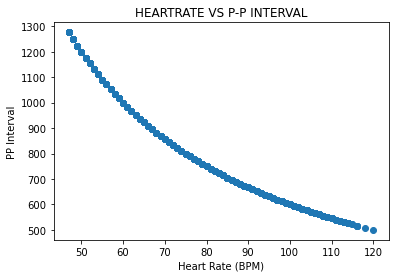

In [27]:
# Relationship between PP interval and HR
plt.scatter(df_intraday_resampled.values,df_PP_interval.values)
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('PP Interval')
plt.title('HEARTRATE VS P-P INTERVAL')

plt.show()

From the above plot, Heart rate and P-P Interval is not a linear relationship. Thus, when comparing the calculated HRV between individuals, the result may not reflect a true comparison. As suggested by Sacha, J. 2013, in the following paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3804770/ the calculated HRV should be normalized by dividing it with the mean HR or P-P interval before comparison. This will need to be catered for in the later stages.

#### The same treatment would be applied for the rest of the days in the records using .groupby() in the following Function:

In [28]:

def Derived_HRV(df):
    '''
    This function resamples and derives the PP intervals from the intraday hr data frame as input df.
    It returns the process df and the days with errors.
    '''
    resample_error = {}
    list_HRV_resampled_all = []

    df_HRV_grouped = df.groupby('date')
    
    day_list = df.date.unique().tolist()

    for day in day_list:
        try:
            df_process = df_HRV_grouped.get_group(day).resample('5S').ffill().bfill()
            # after forward fill the first record will still be missing, thus the backward fill.

            # convert to pp interval
            df_process['pp_interval'] = df_process.value.rolling(1).apply(lambda x : float(60000)/float(x))

            # getting the difference
            df_process['pp_diff'] = df_process.pp_interval.diff(periods=1).fillna(0).abs()

            # calculating the first derivative (division of pp_diff by 5 seconds as the interval is already fixed)
            df_process['pp_1st_derivative'] = df_process.pp_diff / float(5)

            # calculating the second derivative (diff of 1st derivative / 5 sec)
            df_process['pp_2nd_derivative'] = df_process.pp_1st_derivative.diff(periods=1).fillna(0).abs() / float(5)

            list_HRV_resampled_all.append(df_process)

        except Exception as e:
            resample_error[day] = str(e)

    # Concatinating all the Series and returning the error infomation as a tuple:
    return (pd.concat(list_HRV_resampled_all),resample_error)


In [29]:

Subject = PERSON1 # Change here

# The following codes will be repeated for the other subjects.

In [30]:
# NOTE: THIS STEP WILL TAKE A WHILE TO RUN.

# Calling the function to process the full-day and AM/PM dfs:
# Full Day:
df_derived_HRV_full_day,resample_error = Derived_HRV(Subject.df_HR_Full_Days)
df_derived_HRV_full_day

,time,value,date,timestamp,d_timestamp,pp_interval,pp_diff,pp_1st_derivative,pp_2nd_derivative
d_time,,,,,,,,,
2020-02-26 00:00:00,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.000000,0.000000,0.000000
2020-02-26 00:00:05,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.000000,0.000000,0.000000
2020-02-26 00:00:10,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.000000,0.000000,0.000000
2020-02-26 00:00:15,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.000000,0.000000,0.000000
2020-02-26 00:00:20,00:00:18,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2020-07-31 23:58:30,23:58:17,65.0,2020-07-31,-2.208903e+18,1.596240e+18,923.076923,0.000000,0.000000,0.000000
2020-07-31 23:58:35,23:58:32,65.0,2020-07-31,-2.208902e+18,1.596240e+18,923.076923,0.000000,0.000000,0.000000
2020-07-31 23:58:40,23:58:32,65.0,2020-07-31,-2.208902e+18,1.596240e+18,923.076923,0.000000,0.000000,0.000000


In [31]:
# NOTE: THIS STEP WILL TAKE A WHILE TO RUN.

# Half Day (AM):
df_derived_HRV_AM,resample_error_AM = Derived_HRV(Subject.df_HR_Half_AM)
df_derived_HRV_AM

,time,value,date,timestamp,d_timestamp,pp_interval,pp_diff,pp_1st_derivative,pp_2nd_derivative
d_time,,,,,,,,,
2020-02-26 00:00:00,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.0,0.0,0.000000
2020-02-26 00:00:05,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.0,0.0,0.000000
2020-02-26 00:00:10,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.0,0.0,0.000000
2020-02-26 00:00:15,00:00:03,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.0,0.0,0.000000
2020-02-26 00:00:20,00:00:18,83.0,2020-02-26,-2.208989e+18,1.582675e+18,722.891566,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2020-07-31 11:59:35,11:59:26,77.0,2020-07-31,-2.208946e+18,1.596197e+18,779.220779,0.0,0.0,0.410116
2020-07-31 11:59:40,11:59:26,77.0,2020-07-31,-2.208946e+18,1.596197e+18,779.220779,0.0,0.0,0.000000
2020-07-31 11:59:45,11:59:41,77.0,2020-07-31,-2.208946e+18,1.596197e+18,779.220779,0.0,0.0,0.000000


In [32]:
# NOTE: THIS STEP WILL TAKE A WHILE TO RUN.

# Half Day (PM):
df_derived_HRV_PM,resample_error_PM = Derived_HRV(Subject.df_HR_Half_PM)
df_derived_HRV_PM

,time,value,date,timestamp,d_timestamp,pp_interval,pp_diff,pp_1st_derivative,pp_2nd_derivative
d_time,,,,,,,,,
2020-02-23 12:00:00,12:00:03,80.0,2020-02-23,-2.208946e+18,1.582459e+18,750.000000,0.000000,0.000000,0.000000
2020-02-23 12:00:05,12:00:03,80.0,2020-02-23,-2.208946e+18,1.582459e+18,750.000000,0.000000,0.000000,0.000000
2020-02-23 12:00:10,12:00:08,81.0,2020-02-23,-2.208946e+18,1.582459e+18,740.740741,9.259259,1.851852,0.370370
2020-02-23 12:00:15,12:00:08,81.0,2020-02-23,-2.208946e+18,1.582459e+18,740.740741,0.000000,0.000000,0.370370
2020-02-23 12:00:20,12:00:08,81.0,2020-02-23,-2.208946e+18,1.582459e+18,740.740741,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2020-07-31 23:58:30,23:58:17,65.0,2020-07-31,-2.208903e+18,1.596240e+18,923.076923,0.000000,0.000000,0.000000
2020-07-31 23:58:35,23:58:32,65.0,2020-07-31,-2.208902e+18,1.596240e+18,923.076923,0.000000,0.000000,0.000000
2020-07-31 23:58:40,23:58:32,65.0,2020-07-31,-2.208902e+18,1.596240e+18,923.076923,0.000000,0.000000,0.000000


In [33]:
print("There were errors in resampling the following days in the Full Day DF :")
for x,y in resample_error.items():
    print(x,':',y)

print("\nThere were errors in resampling the following days in the AM DF :")
for x,y in resample_error_AM.items():
    print(x,':',y)
    
print("\nThere were errors in resampling the following days in the PM DF :")
for x,y in resample_error.items():
    print(x,':',y)

There were errors in resampling the following days in the Full Day DF :
2020-04-10 : cannot reindex a non-unique index with a method or limit
2020-04-17 : cannot reindex a non-unique index with a method or limit
2020-05-24 : cannot reindex a non-unique index with a method or limit

There were errors in resampling the following days in the AM DF :
2020-04-04 : cannot reindex a non-unique index with a method or limit
2020-04-10 : cannot reindex a non-unique index with a method or limit
2020-04-17 : cannot reindex a non-unique index with a method or limit
2020-05-24 : cannot reindex a non-unique index with a method or limit
2020-05-28 : cannot reindex a non-unique index with a method or limit

There were errors in resampling the following days in the PM DF :
2020-04-10 : cannot reindex a non-unique index with a method or limit
2020-04-17 : cannot reindex a non-unique index with a method or limit
2020-05-24 : cannot reindex a non-unique index with a method or limit


In [34]:
def Compiled_HRV_Stats(df_derived_HRV):
    '''
    This function compiles the stats like max,min,sd,mean and derivative of pp_intervals derived 
    from the previous HRV df, "df_derived_HRV"
    '''
    new_df = pd.DataFrame()
    
    # Max, Min, Mean, Range of PP intervals and Standard Deviation (SDRR)
    new_df['Max_PP_interval'] = df_derived_HRV.groupby('date').pp_interval.max()
    new_df['Min_PP_interval'] = df_derived_HRV.groupby('date').pp_interval.min()
    new_df['SD_PP_interval'] = df_derived_HRV.groupby('date').pp_interval.std() # SDRR
    new_df['Mean_PP_interval'] = df_derived_HRV.groupby('date').pp_interval.mean()
    new_df['PP_interval_range'] = new_df.Max_PP_interval - new_df.Min_PP_interval

    # Calculating SDANN
    # Resample to 5 minutes and calculate the Standard Deviation of the average of each group
    df_derived_HRV_5mins = df_derived_HRV.groupby('date').resample('5Min').mean()
    new_df['SD_PP_5min'] = df_derived_HRV_5mins.groupby('date').pp_interval.std()

    # Calculating RMS for PP Successive Interval difference
    df_derived_HRV['Squared_PP_diff'] = np.square(df_derived_HRV.pp_diff) # Square of diff
    new_df['RMS_PP_diff'] = df_derived_HRV.groupby('date').Squared_PP_diff.mean()
    new_df['RMS_PP_diff'] = np.sqrt(new_df.RMS_PP_diff)

    # Calculating the Derivatives of the PP Interval
    # the minimum of the derivaives will be excluded as it will be definately be 0.
    new_df['Max_PP_1st_dydt'] = df_derived_HRV.groupby('date').pp_1st_derivative.max()
    new_df['SD_PP_1st_dydt'] = df_derived_HRV.groupby('date').pp_1st_derivative.std()

    #Second Derivatives
    new_df['Max_PP_2nd_dydt'] = df_derived_HRV.groupby('date').pp_2nd_derivative.max()
    new_df['SD_PP_2nd_dydt'] = df_derived_HRV.groupby('date').pp_2nd_derivative.std()

    return new_df


In [35]:
# Calling the function for Full day, AM and PM DFs:

# Full Day:
PERSON1.df_hrv_stats_full_day = Compiled_HRV_Stats(df_derived_HRV_full_day)
PERSON1.df_hrv_stats_full_day


,Max_PP_interval,Min_PP_interval,SD_PP_interval,Mean_PP_interval,PP_interval_range,SD_PP_5min,RMS_PP_diff,Max_PP_1st_dydt,SD_PP_1st_dydt,Max_PP_2nd_dydt,SD_PP_2nd_dydt
date,,,,,,,,,,,
2020-02-26,1276.595745,500.000000,162.551351,899.645812,776.595745,152.288575,22.161224,69.707401,3.844838,11.919612,0.751220
2020-02-27,1304.347826,441.176471,176.099620,876.242585,863.171355,166.404115,22.293061,68.607069,3.810468,13.721414,0.742067
2020-02-28,1250.000000,458.015267,146.807368,873.208981,791.984733,135.206961,22.197500,60.555088,3.830093,11.904762,0.756564
2020-02-29,1276.595745,410.958904,147.758691,883.056559,865.636841,137.317821,18.601153,56.390977,3.286330,11.076923,0.639132
2020-03-01,1304.347826,472.440945,198.042279,936.929742,831.906881,188.219051,23.006086,94.897959,3.948118,18.979592,0.808380
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-25,1304.347826,402.684564,158.043198,1004.586109,901.663262,144.952437,26.986297,66.415094,4.533282,13.283019,0.873019
2020-07-26,1428.571429,447.761194,221.390249,961.160662,980.810235,213.630667,23.318217,62.031533,3.950721,12.406307,0.772212
2020-07-27,1276.595745,437.956204,166.500560,852.129840,838.639540,157.425040,21.144231,70.323488,3.637569,14.064698,0.719270


In [36]:
# AM:
PERSON1.df_hrv_stats_AM = Compiled_HRV_Stats(df_derived_HRV_AM)
PERSON1.df_hrv_stats_AM

,Max_PP_interval,Min_PP_interval,SD_PP_interval,Mean_PP_interval,PP_interval_range,SD_PP_5min,RMS_PP_diff,Max_PP_1st_dydt,SD_PP_1st_dydt,Max_PP_2nd_dydt,SD_PP_2nd_dydt
date,,,,,,,,,,,
2020-02-26,1276.595745,500.000000,181.689887,966.895528,776.595745,169.898903,26.647152,69.707401,4.537718,11.919612,0.882722
2020-02-27,1304.347826,441.176471,184.614500,972.377586,863.171355,171.988728,26.447855,68.607069,4.530461,13.721414,0.871685
2020-02-28,1250.000000,458.015267,149.723572,939.077110,791.984733,135.070572,26.602351,60.555088,4.600946,11.904762,0.906132
2020-02-29,1276.595745,410.958904,162.648181,916.155669,865.636841,153.043162,19.751083,56.390977,3.621011,11.076923,0.703383
2020-03-01,1304.347826,472.440945,176.049613,1072.507515,831.906881,159.825306,27.948029,94.897959,4.837239,18.979592,1.001381
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-26,1428.571429,447.761194,168.451036,1131.062117,980.810235,153.823922,28.934058,62.031533,4.915546,12.406307,0.951948
2020-07-27,1224.489796,437.956204,172.610339,889.385365,786.533592,164.038671,23.973253,70.323488,4.195769,14.064698,0.836511
2020-07-28,1304.347826,458.015267,174.792930,1020.170118,846.332559,160.548226,28.869258,81.447964,4.955044,16.289593,0.973120


In [37]:
# PM:
PERSON1.df_hrv_stats_PM = Compiled_HRV_Stats(df_derived_HRV_PM)
PERSON1.df_hrv_stats_PM

,Max_PP_interval,Min_PP_interval,SD_PP_interval,Mean_PP_interval,PP_interval_range,SD_PP_5min,RMS_PP_diff,Max_PP_1st_dydt,SD_PP_1st_dydt,Max_PP_2nd_dydt,SD_PP_2nd_dydt
date,,,,,,,,,,,
2020-02-23,1200.000000,500.000000,102.165442,838.551981,700.000000,87.063390,19.231443,43.137255,3.132500,8.627451,0.605979
2020-02-24,1071.428571,461.538462,110.265920,750.089800,609.890110,99.456829,15.030229,35.000000,2.386580,5.529412,0.462096
2020-02-25,1090.909091,491.803279,120.304697,779.770848,599.105812,113.214584,14.020008,27.131783,2.398700,5.357143,0.473496
2020-02-26,1111.111111,517.241379,103.758196,832.293925,593.869732,92.632057,16.487857,40.106952,2.875794,6.888533,0.570878
2020-02-27,1034.482759,491.803279,97.110412,780.008754,542.679480,86.047988,17.156268,30.303030,2.857635,6.060606,0.574165
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,1276.595745,500.000000,151.227548,814.828851,776.595745,141.678396,17.868278,63.079777,2.966715,12.615955,0.576445
2020-07-28,1153.846154,517.241379,103.504030,849.323491,636.604775,91.634245,17.267578,29.476787,2.754162,5.194013,0.529955
2020-07-29,983.606557,495.867769,85.934439,715.202413,487.738789,77.995307,11.986521,34.378160,1.924970,6.875632,0.370708


### USING TSFresh Custom Function
we can use TSFresh custom function for other DFs

In [ ]:
# Calculation using TSFresh simple custom function for a singular time series,
# following the examples given by TSFresh:

from tsfresh.feature_extraction.feature_calculators import set_property

@set_property("fctype", "simple")
@set_property("input", "pd.Series")

def max_minus_min(x, param):
    '''
    TSFresh custom function to calculate Difference between Max & Min:
    (MAX - MIN)
    x = time series df
    param = colume name to use, in str
    '''
    HR_max = x[param].max()
    HR_min = x[param].min()
    
#    # Get differences between the last timestamp and the first timestamp
#     time_diff = (ix[-1] - ix[0]).total_seconds() # over the time past
    
    # Calculate difference between max & min:
    f = HR_max - HR_min
    
    return f
    

In order to add the custom feature into TSFresh, the following step is carried out to include the new function:

In [ ]:
# Adding the custom function:

tsfresh.feature_extraction.settings.feature_calculators.__dict__.update(
    {'max_minus_min': max_minus_min})

# Verifying the custom function is added:
# tsfresh.feature_extraction.settings.feature_calculators.__dict__.items()


In [ ]:
# Calculating the Max - Min for Heart Rate:
import tsfresh.feature_extraction.feature_calculators as tsf_cal

PERSON1.df_HR_stats_full = pd.DataFrame()

PERSON1.df_HR_stats_full['Max_minus_min_HR'] = PERSON1.df_HR_Full_Days.groupby('date').apply(
    lambda x: tsf_cal.max_minus_min(x,'value'))

PERSON1.df_HR_stats_full

### Using TSFresh to extract other features
DFs:
- HRV_Stats_Full_Days
- HRV_Stats_AM
- HRV_Stats_PM
- Resting HR
- Sleep Durations
- Calories
- Steps Activity

TSFresh features like: index_mass_quantile

In [32]:
# Preparing the DF to use TSFresh, adding a ID column.
# The SUBJECTS can be used as ID, eg. person1, person2,...
# Date can be used as well.

timeseries = PERSON1.df_HR_Full_Days.groupby('date').get_group('2020-02-26')
timeseries['subj'] = 'person1'

timeseries

C:\Users\jia92\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,value,date,timestamp,d_timestamp,subj
d_time,,,,,,
2020-02-26 00:00:03,00:00:03,83,2020-02-26,-2208988797000000000,1582675203000000000,person1
2020-02-26 00:00:18,00:00:18,83,2020-02-26,-2208988782000000000,1582675218000000000,person1
2020-02-26 00:00:28,00:00:28,85,2020-02-26,-2208988772000000000,1582675228000000000,person1
2020-02-26 00:00:33,00:00:33,84,2020-02-26,-2208988767000000000,1582675233000000000,person1
2020-02-26 00:00:38,00:00:38,82,2020-02-26,-2208988762000000000,1582675238000000000,person1
...,...,...,...,...,...,...
2020-02-26 23:58:32,23:58:32,59,2020-02-26,-2208902488000000000,1582761512000000000,person1
2020-02-26 23:58:37,23:58:37,59,2020-02-26,-2208902483000000000,1582761517000000000,person1
2020-02-26 23:58:42,23:58:42,60,2020-02-26,-2208902478000000000,1582761522000000000,person1


In [33]:
# This Runs too long...

# extracted_features = tsfresh.extract_features(timeseries, column_id="subj",
#                                               column_sort="time", column_value="value")
# extracted_features

### SAVING THE PROCESSED DF TO PICKLE

Establish folder path:

In [38]:
current_directory = os.getcwd()
folder = os.path.join("PERSON1","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)


Save to Pickle file:

In [39]:
# DUMP THE DERIVED HRV DFs INTO PICKLE:

pickle_list = {
                'df_hrv_stats_full_day':PERSON1.df_hrv_stats_full_day,
                'df_hrv_stats_AM':PERSON1.df_hrv_stats_AM,
                'df_hrv_stats_PM':PERSON1.df_hrv_stats_PM

                }

# Save to Pickle:
for i in pickle_list.keys():
    file = folder_path + '/' + str(i) + '.pickle'
    with open(file,'wb') as f:
        pickle.dump(obj=pickle_list[i],file=f)


In [42]:

file = 'C:/Users/jia92/Documents/Jupyter/FYP/IntelligentHealthMonitoring/PERSON1/31JUL/df_hrv_stats_full_day.pickle'
with open(file,'rb') as f:
    test = pickle.load(file=f)
    
print(test)

            Max_PP_interval  Min_PP_interval  SD_PP_interval  \
date                                                           
2020-02-26      1276.595745       500.000000      162.551351   
2020-02-27      1304.347826       441.176471      176.099620   
2020-02-28      1250.000000       458.015267      146.807368   
2020-02-29      1276.595745       410.958904      147.758691   
2020-03-01      1304.347826       472.440945      198.042279   
...                     ...              ...             ...   
2020-07-25      1304.347826       402.684564      158.043198   
2020-07-26      1428.571429       447.761194      221.390249   
2020-07-27      1276.595745       437.956204      166.500560   
2020-07-28      1304.347826       458.015267      167.141707   
2020-07-31      1250.000000       483.870968      148.105529   

            Mean_PP_interval  PP_interval_range  SD_PP_5min  RMS_PP_diff  \
date                                                                       
2020-02-26     

After extracting the features from TSFresh, they can be tag to a profile and then compared with other subjects. TSFRESH Was not Used in this project.

### Next Step: Visualisation of Derived Features

This will be done another Jupyter Notebook.